In [1]:
from pathlib import Path
import pandas as pd
import re

In [2]:
#Get the list of all of the step files
step_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[dD][wW][iI]"))

#Get the list of all of the step files
song_files = list(Path("C:/Users/brent/Desktop/StepMania 5").rglob("*.[mM][pP][3]"))

In [3]:
print(len(song_files), len(step_files))

444 340


In [4]:
def process_song(path, title):
    #Open File
    text_file = open(path, "r")
    lines = text_file.readlines()
    text_file.close()
    
    #Combine all text into single line
    song = "".join(lines)
    
    #Remove newline characters
    song = re.sub('\n', '', song)
    
    #Split on semicolon and then add the semicolons back into the respective lines
    song = song.split(';')
    song = [line+';' for line in song][:-1]
    
    #Remove lines that start with 2 // (some files had this for some reason)
    song = [line for line in song if (line.find('//') == -1)]
    
    #Create a dataframe of the song
    df = pd.DataFrame()
    df[title] = song
    return df

def pull_all_step_patterns(song, row):
    song = song[row].str.split(":", n = 3, expand = True)
    song = song[song[0].isin(["#SINGLE","#SOLO"])]
    
    return song

def join_all_step_patterns(step_files):
    songs = pd.DataFrame()
    for row, path in enumerate(step_files):
        df = process_song(path, row)
        df = pull_all_step_patterns(df, row)
        #songs = pd.merge(songs, df, left_index=True, right_index=True, how="outer")
        songs = pd.concat([songs,df])
    
    return songs

In [5]:
songs = join_all_step_patterns(step_files)

In [6]:
songs = songs.reset_index()
songs = songs[[1,3]]
songs.columns = ['label','text']

#Split the song into characters with spaces
songs['text'] = songs['text'].apply(lambda x: " ".join(x))

#Remove the trailing semicolon as we can add it back in when we are done predicting songs
songs['text'] = songs['text'].apply(lambda x: x[:-1])

In [7]:
songs.head()

,label,text
0,BEGINNER,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,BASIC,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,ANOTHER,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,MANIAC,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,SMANIAC,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [8]:
songs.to_csv("songs.csv", index=False)

# Train our Language Model

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

In [10]:
cwd = os.getcwd()
path = Path(cwd)
#path.ls()

In [11]:
# #We don't want to remove repetition in the DDR song as that is part of it
# customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

# data_lm = TextDataBunch.from_csv(path, 'songs.csv', valid_pct = 0.2, tokenizer= customtokenizer)

# data_lm.save('data_lm.pkl')

In [12]:
# data_clas = TextClasDataBunch.from_csv(path, 'songs.csv', valid_pct = 0.2, tokenizer= customtokenizer)
# data_clas.show_batch()

# data_clas.save('data_clas.pkl')

In [13]:
from pathlib import Path
import pandas as pd
import re
import string

%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os

cwd = os.getcwd()
path = Path(cwd)

In [ ]:
#This functions without tokenization based on 

# data_lm = TextDataBunch.from_csv(path, 'songs.csv', valid_pct = 0.2, tokenizer= customtokenizer)
# data_lm.save('data_lm.pkl')

In [14]:
#Need to figure out how to use tokenizatoin and numericalization properly as it is inserting the repetition token
#Try out the datablock API to see if we can replicate and use either no tokenization or our custom tokenizer

all_letters = string.printable + string.whitespace

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

#vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))

processors = [TokenizeProcessor(customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data = (TextList.from_csv(path, 'songs.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_for_lm()
                .databunch(bs=12))
data.save('data_block_lm.pkl')

In [28]:
data_lm = load_data(path, 'data_block_lm.pkl',bs=12)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


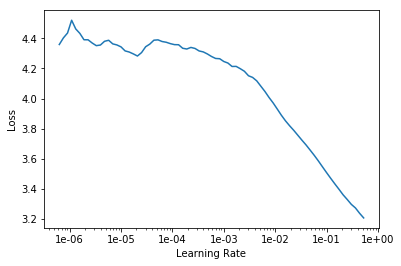

In [29]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [30]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.577643,1.504219,0.483242,00:49
1,1.467229,1.428542,0.501618,00:49
2,1.441695,1.396514,0.515957,00:49
3,1.404007,1.380613,0.518658,00:48


In [31]:
learn.save('fit_head')

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.338816,1.339212,0.524130,00:59
1,1.301011,1.296371,0.537538,01:00
2,1.227769,1.257159,0.556655,01:00
3,1.208677,1.214103,0.574458,01:00
4,1.163127,1.183493,0.583952,00:58
5,1.129814,1.167257,0.591644,00:59
6,1.076365,1.155492,0.596940,01:01
7,1.036998,1.152000,0.601412,01:01
8,0.989840,1.154566,0.602267,01:01
9,0.960400,1.156533,0.602289,01:01


In [34]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

In [35]:
TEXT = ""
N_WORDS = 40
N_SENTENCES = 1
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8 0 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 8 8 8 8 8 8 8 8


# Now we work on the classifier

In [36]:
#Need to figure out how to use tokenizatoin and numericalization properly as it is inserting the repetition token

#Try out the datablock API to see if we can replicate and use either no tokenization or our custom tokenizer

all_letters = string.printable + string.whitespace

#We don't want to remove repetition in the DDR song as that is part of it
customtokenizer = Tokenizer(pre_rules= [], post_rules=[])

processors = [TokenizeProcessor(customtokenizer, mark_fields=False),
            NumericalizeProcessor(vocab=Vocab.create(all_letters, max_vocab=1000, min_freq=0))]

data_clas = (TextList.from_csv(path, 'songs.csv', cols='text', processor=processors)
                .split_by_rand_pct(0.2)
                .label_from_df('label')
                .databunch(bs=12))

In [37]:
data_clas.save('data_clas.pkl')

In [38]:
data_clas = load_data(path, 'data_clas.pkl', bs=12)
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


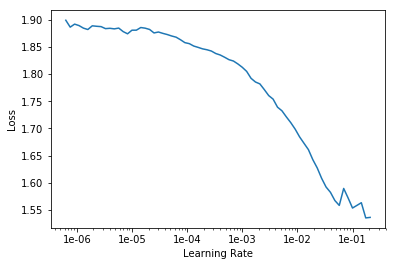

In [39]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [40]:
learn.fit_one_cycle(4, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.043479,0.679213,0.745819,00:57
1,0.843732,0.593246,0.779264,00:57
2,0.728868,0.572644,0.749164,00:57
3,0.655461,0.551928,0.785953,00:57


In [41]:
learn.save('original_classifier')

In [42]:
learn.unfreeze()

In [43]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.671166,0.536883,0.775920,01:25
1,0.588969,0.544704,0.792642,01:23
2,0.672095,0.537546,0.789298,01:24
3,0.601338,0.494251,0.819398,01:24
4,0.582720,0.525258,0.795987,01:24
5,0.584252,0.492913,0.802676,01:24
6,0.511831,0.512687,0.806020,01:24
7,0.507256,0.565742,0.779264,01:22
8,0.462546,0.544987,0.782609,01:20
9,0.436205,0.537085,0.799331,01:21


In [44]:
learn.save('fine_tuned_classifier')
learn.save_encoder('fine_tuned_enc_classifier')

## What are the most frequently misclassified?

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

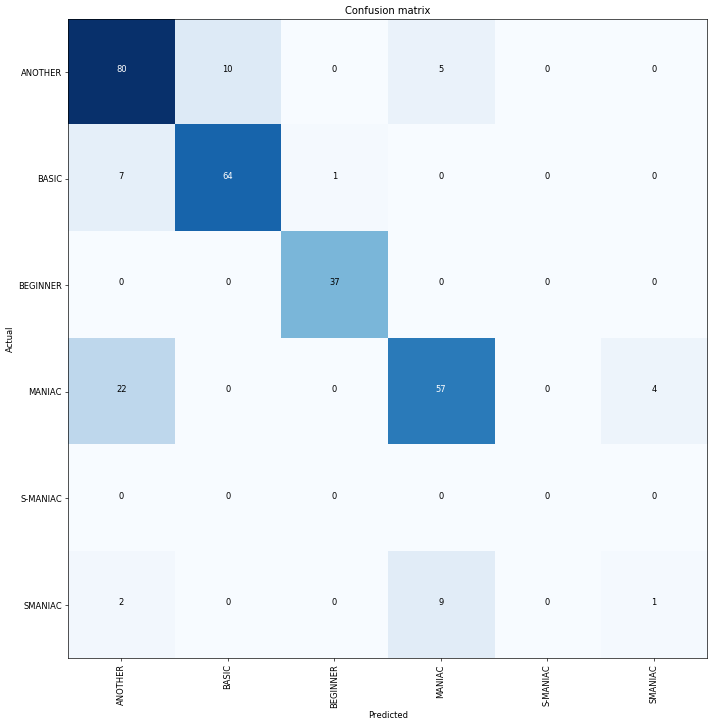

In [46]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [47]:
interp.most_confused(min_val=2)

[('MANIAC', 'ANOTHER', 22),
 ('ANOTHER', 'BASIC', 10),
 ('SMANIAC', 'MANIAC', 9),
 ('BASIC', 'ANOTHER', 7),
 ('ANOTHER', 'MANIAC', 5),
 ('MANIAC', 'SMANIAC', 4),
 ('SMANIAC', 'ANOTHER', 2)]